In [4]:
import sys
print(sys.executable)

/opt/homebrew/opt/python@3.11/bin/python3.11


In [1]:
!pip3 install pandas


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip


In [3]:
import pandas as pd

rel_df  = pd.read_csv("app_query_relationships.csv")
meta_df = pd.read_csv("app_categories.csv")

# 🔸 Ensure the 5 columns we want actually exist.
needed_cols = ["package", "category", "developer", "installs", "rating"]
for col in needed_cols:
    if col not in meta_df.columns:
        meta_df[col] = pd.NA       # create empty column if missing

# Now safe to slice and merge
rel_df = (
    rel_df.merge(
        meta_df[needed_cols],
        left_on="queried_package",
        right_on="package",
        how="left",
        suffixes=("", "_target"),
    )
)

print("Merged shape:", rel_df.shape)
rel_df.head()

# … then run the Top-3 insight dashboard cell


Merged shape: (4470, 7)


,app_package,queried_package,package,category,developer,installs,rating
0,in.startv.hotstar,net.one97.paytm,net.one97.paytm,Payment,<NA>,<NA>,<NA>
1,in.startv.hotstar,net.one97.paytm,net.one97.paytm,Payment,<NA>,<NA>,<NA>
2,in.startv.hotstar,net.one97.paytm,net.one97.paytm,Payment,<NA>,<NA>,<NA>
3,in.startv.hotstar,net.one97.paytm,net.one97.paytm,Payment,<NA>,<NA>,<NA>
4,in.startv.hotstar,com.google.android.gms.policy_cast_dynamite,com.google.android.gms.policy_cast_dynamite,Utilities,<NA>,<NA>,<NA>


In [3]:

import os
import xml.etree.ElementTree as ET
import pandas as pd

ANDROID_NS = "http://schemas.android.com/apk/res/android"
MANIFEST_DIR = "android-manifest-files"





In [4]:
def parse_manifest(filepath):
    try:
        tree = ET.parse(filepath)
        root = tree.getroot()
        app_package = root.attrib.get("package")
        queried_packages = []

        for queries in root.findall("queries"):
            for pkg in queries.findall("package"):
                name = pkg.attrib.get(f"{{{ANDROID_NS}}}name")
                if name:
                    queried_packages.append(name)

        return app_package, queried_packages
    except:
        return None, []


In [5]:
results = []

for root, _, files in os.walk(MANIFEST_DIR):
    for file in files:
        if file.endswith("AndroidManifest.xml"):
            path = os.path.join(root, file)
            app, queries = parse_manifest(path)
            if app and queries:
                for q in queries:
                    results.append({
                        "app_package": app,
                        "queried_package": q
                    })

print(f"Extracted {len(results)} app → queried app relationships.")




Extracted 3424 app → queried app relationships.


In [7]:
df = pd.DataFrame(results)
df.head(1000)



,app_package,queried_package
0,in.startv.hotstar,net.one97.paytm
1,in.startv.hotstar,com.google.android.gms.policy_cast_dynamite
2,in.startv.hotstar,androidx.test.orchestrator
3,in.startv.hotstar,androidx.test.services
4,in.startv.hotstar,com.google.android.apps.common.testing.services
...,...,...
995,com.whizdm.moneyview.loans,com.loangopro.bestloanapp
996,com.whizdm.moneyview.loans,com.Loanindiaon
997,com.whizdm.moneyview.loans,com.loanklub.cwtapp
998,com.whizdm.moneyview.loans,com.loanpelite.loanapp


In [8]:
df.to_csv("app_query_relationships.csv", index=False)
df.to_json("app_query_relationships.json", orient="records", indent=2)



In [9]:
import pandas as pd

df = pd.read_csv("app_query_relationships.csv")

In [11]:
df[df["app_package"].str.contains("axis", case=False)]

,app_package,queried_package
604,com.axis.mobile,com.tencent.mm
605,com.axis.mobile,com.whatsapp
606,com.axis.mobile,us.zoom.videomeetings
607,com.axis.mobile,com.google.android.gms.policy_cast_dynamite
608,com.axis.mobile,com.google.android.apps.maps
609,com.axis.mobile,com.facebook.katana
610,com.axis.mobile,com.instagram.android
611,com.axis.mobile,com.facebook.lite
612,com.axis.mobile,com.samsung.android.mapsagent
613,com.axis.mobile,com.android.vending


In [12]:
queried = df["queried_package"].dropna().unique()
pd.Series(queried).to_csv("all_queried_packages.csv", index=False, header=["package"])


=== Category ➜ Category (% of queries) ===


target_category,Business,Delivery,Education,Entertainment,Finance,Gaming,Health,Lifestyle,Messaging,Navigation,Others,Payment,Shopping,Social,Transport,Travel,Utilities,unknown
source_category,,,,,,,,,,,,,,,,,,
Delivery,0.0,8.7,0.0,1.6,4.8,0.9,0.0,0.6,6.3,2.9,1.1,15.7,6.1,12.1,3.7,0.6,4.1,30.9
Entertainment,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,50.0,0.0
Finance,0.2,0.7,0.0,0.4,5.5,0.5,0.0,0.4,2.9,0.7,0.6,10.2,2.0,4.0,0.9,0.4,3.4,67.0
Gaming,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.3,0.0,0.0,11.4,5.7,48.6,0.0,0.0,8.6,11.4
Others,0.0,0.0,0.0,0.0,3.3,0.0,0.0,0.0,42.6,9.8,0.0,6.6,9.8,14.8,0.0,0.0,8.2,4.9
Payment,0.0,0.0,0.0,1.8,0.0,0.0,0.0,0.0,16.1,5.4,0.0,7.1,8.9,39.3,0.0,0.0,0.9,20.5
Shopping,0.0,2.2,0.0,0.0,0.0,0.0,0.0,0.0,16.3,3.3,0.0,26.1,8.7,29.3,0.0,0.0,5.4,8.7
Transport,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.8,0.0,0.0,31.6,47.4,0.0,0.0,5.3,0.0
Utilities,0.0,0.0,0.0,4.6,1.7,0.0,0.0,0.0,6.9,2.6,0.6,14.5,4.0,2.3,0.0,0.0,10.4,52.3



=== Top 20 apps that query the most other apps ===


,app_package,num_queries
0,com.whizdm.moneyview.loans,988
1,com.kreditbee.android,909
2,com.zeptoconsumerapp,627
3,com.nextbillion.groww,366
4,in.swiggy.android.instamart,219
5,in.swiggy.android,219
6,com.jio.myjio,178
7,in.swiggy.deliveryapp,171
8,com.myairtelapp,168
9,in.indwealth,107


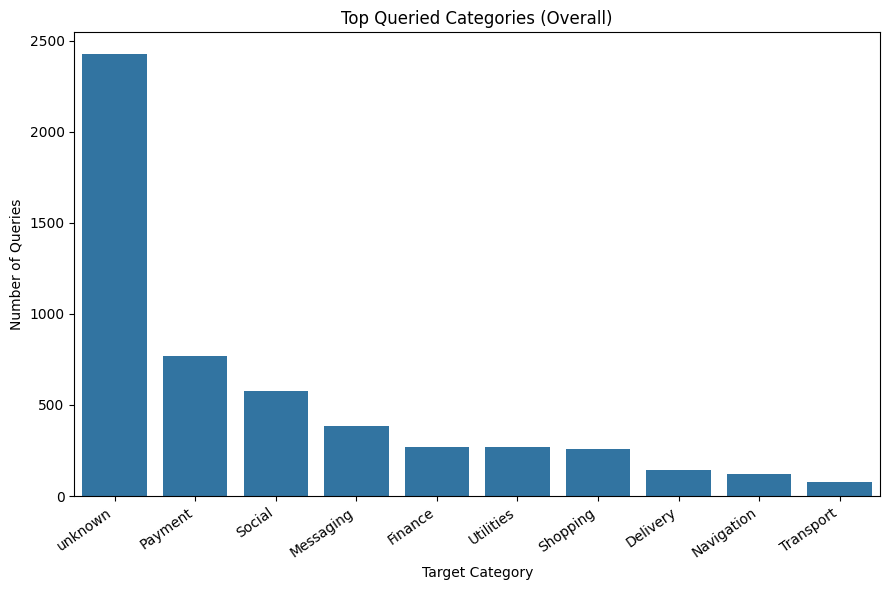

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display  # <— built-in in every notebook

# ------------------------------------------------------------------
# 1. Load the two CSVs (assumes they’re in the same folder as notebook)
# ------------------------------------------------------------------
rel_path = Path("app_query_relationships.csv")
cat_path = Path("app_categories.csv")

rel_df = pd.read_csv(rel_path)
cat_df = pd.read_csv(cat_path)

# ------------------------------------------------------------------
# 2. Merge source/target categories
# ------------------------------------------------------------------
cat_map = cat_df.set_index("package")[["category", "subcategory"]]

rel_df = rel_df.merge(
    cat_map, left_on="app_package", right_index=True, how="left", suffixes=("", "_src")
)
rel_df = rel_df.merge(
    cat_map, left_on="queried_package", right_index=True, how="left", suffixes=("", "_tgt")
)

rel_df.rename(
    columns={
        "category": "source_category",
        "subcategory": "source_subcategory",
        "category_tgt": "target_category",
        "subcategory_tgt": "target_subcategory",
    },
    inplace=True,
)

rel_df[["source_category", "source_subcategory",
        "target_category", "target_subcategory"]] = (
    rel_df[["source_category", "source_subcategory",
            "target_category", "target_subcategory"]].fillna("unknown")
)

# ------------------------------------------------------------------
# 3-A. Insight 1 — Category → Category % matrix
# ------------------------------------------------------------------
cat_matrix = (
    rel_df.groupby(["source_category", "target_category"])
          .size()
          .unstack(fill_value=0)
)
cat_pct = (cat_matrix.div(cat_matrix.sum(axis=1), axis=0) * 100).round(1)

print("=== Category ➜ Category (% of queries) ===")
display(cat_pct)

# ------------------------------------------------------------------
# 3-B. Insight 2 — Top 20 querying apps
# ------------------------------------------------------------------
top_apps = (
    rel_df.groupby("app_package").size()
          .sort_values(ascending=False)
          .head(20)
          .reset_index(name="num_queries")
)

print("\n=== Top 20 apps that query the most other apps ===")
display(top_apps)

# ------------------------------------------------------------------
# 3-C. Insight 3 — Bar chart of most-queried target categories
# ------------------------------------------------------------------
target_counts = rel_df["target_category"].value_counts().head(10)

plt.figure(figsize=(9, 6))
sns.barplot(x=target_counts.index, y=target_counts.values)
plt.title("Top Queried Categories (Overall)")
plt.ylabel("Number of Queries")
plt.xlabel("Target Category")
plt.xticks(rotation=35, ha="right")
plt.tight_layout()
plt.show()



🔹 Source categories generating the most queries


,source_category,0
0,Finance,2453
1,unknown,1163
2,Delivery,1032



🔹 Target categories most frequently queried


,target_category,0
0,unknown,2424
1,Payment,768
2,Social,577



🔹 Source→Target category pairs with highest counts


,source_category,target_category,count
0,Finance,unknown,1644
1,Delivery,unknown,319
2,unknown,Payment,254



🔹 Apps that query the most others


,app_package,0
0,com.whizdm.moneyview.loans,988
1,com.kreditbee.android,909
2,com.zeptoconsumerapp,627



🔹 Apps most often queried by others


,queried_package,0
0,com.instagram.android,245
1,com.facebook.katana,216
2,com.phonepe.app,172



🔹 Target subcategories most frequently queried


,target_subcategory,0
0,unknown,2462
1,wallet/UPI,453
2,photo/video sharing,245


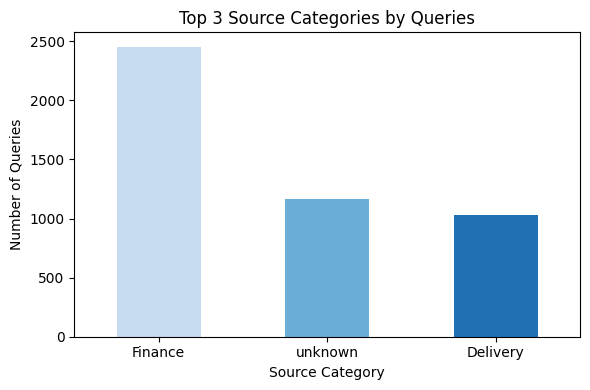

In [28]:
# ============================================================
# EXTRA INSIGHTS  – Top-3’s everywhere
# ============================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# ---------- Helper to pretty-print Top-N ---------------------
def show_top_n(series, n=3, title="Top items"):
    top_n = series.nlargest(n)
    print(f"\n🔹 {title}")
    display(top_n.reset_index().rename(columns={series.name: "count"}))

# ---------- 1. Top-3 SOURCE categories (who initiates queries)
src_totals = rel_df.groupby("source_category").size()
show_top_n(src_totals, 3, "Source categories generating the most queries")

# ---------- 2. Top-3 TARGET categories (most queried overall)
tgt_totals = rel_df.groupby("target_category").size()
show_top_n(tgt_totals, 3, "Target categories most frequently queried")

# ---------- 3. Top-3 SOURCE→TARGET category pairs
pair_totals = (
    rel_df.groupby(["source_category", "target_category"])
          .size()
          .sort_values(ascending=False)
          .head(3)
)
print("\n🔹 Source→Target category pairs with highest counts")
display(pair_totals.reset_index(name="count"))

# ---------- 4. Top-3 QUERYING apps (unique source apps) -------
top_apps = rel_df.groupby("app_package").size()
show_top_n(top_apps, 3, "Apps that query the most others")

# ---------- 5. Top-3 MOST-QUERIED apps (unique targets) ------
top_targets = rel_df.groupby("queried_package").size()
show_top_n(top_targets, 3, "Apps most often queried by others")

# ---------- 6. Top-3 TARGET **sub-**categories ---------------
tgt_sub_totals = rel_df.groupby("target_subcategory").size()
show_top_n(tgt_sub_totals, 3, "Target subcategories most frequently queried")

# ---------- 7. Quick bar chart – Top-3 source categories -----
plt.figure(figsize=(6,4))
src_totals.nlargest(3).plot(kind="bar", color=sns.color_palette("Blues", 3))
plt.title("Top 3 Source Categories by Queries")
plt.ylabel("Number of Queries")
plt.xlabel("Source Category")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()



🔸 Source categories generating the most queries


,source_category,0
0,Finance,2453
1,unknown,1163
2,Delivery,1032



→ Share (%) of all queries:


,percent
source_category,
Finance,44.8
unknown,21.3
Delivery,18.9



🔸 Target categories most frequently queried


,target_category,0
0,unknown,2424
1,Payment,768
2,Social,577



🔸 Source → Target category pairs with highest counts


,source_category,target_category,0
0,Finance,unknown,1644
1,Delivery,unknown,319
2,unknown,Payment,254



🔸 Apps issuing the greatest number of queries


,app_package,0
0,com.whizdm.moneyview.loans,988
1,com.kreditbee.android,909
2,com.zeptoconsumerapp,627



🔸 Apps most often queried by others


,queried_package,0
0,com.instagram.android,245
1,com.facebook.katana,216
2,com.phonepe.app,172



🔸 Target sub-categories most frequently queried


,target_subcategory,0
0,unknown,2462
1,wallet/UPI,453
2,photo/video sharing,245


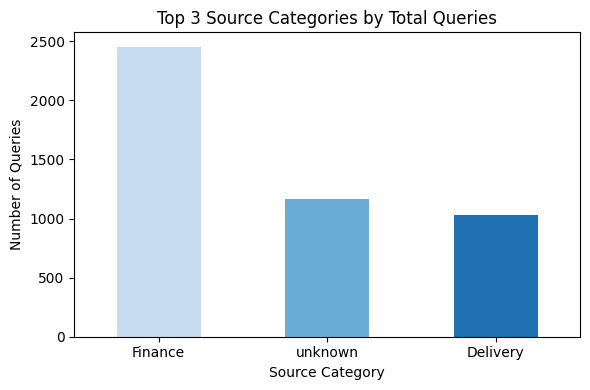

In [31]:
# ============================================================
# INSIGHT DASHBOARD – “Top-3” Lists Everywhere
# (No fancy HTML; uses plain DataFrame display.)
# ============================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# ---------------------------------------------
# Helper: pretty-print Top-N rows of a Series
# ---------------------------------------------
def show_top(series, n=3, title="Top items"):
    topn = (series.nlargest(n)
                    .reset_index()
                    .rename(columns={series.name: "count"}))
    print(f"\n🔸 {title}")
    display(topn)

# 1) Top Source Categories (count & % share)
src_counts = rel_df.groupby("source_category").size().sort_values(ascending=False)
src_pct = (src_counts / src_counts.sum() * 100).round(1)

show_top(src_counts, 3, "Source categories generating the most queries")
print("\n→ Share (%) of all queries:")
display(src_pct.head(3).to_frame("percent"))

# 2) Top Target Categories
tgt_counts = rel_df.groupby("target_category").size().sort_values(ascending=False)
show_top(tgt_counts, 3, "Target categories most frequently queried")

# 3) Top Source → Target Category Pairs
pair_counts = (rel_df.groupby(["source_category", "target_category"])
                       .size()
                       .sort_values(ascending=False))
show_top(pair_counts, 3, "Source → Target category pairs with highest counts")

# 4) Apps that query the most others
top_query_apps = (rel_df.groupby("app_package").size()
                             .sort_values(ascending=False))
show_top(top_query_apps, 3, "Apps issuing the greatest number of queries")

# 5) Most-queried target apps
most_queried = (rel_df.groupby("queried_package").size()
                           .sort_values(ascending=False))
show_top(most_queried, 3, "Apps most often queried by others")

# 6) Top Target Sub-categories
tgt_sub_counts = rel_df.groupby("target_subcategory").size().sort_values(ascending=False)
show_top(tgt_sub_counts, 3, "Target sub-categories most frequently queried")

# 7) Quick bar chart – Top 3 Source Categories
plt.figure(figsize=(6,4))
src_counts.head(3).plot(kind="bar", color=sns.color_palette("Blues", 3))
plt.title("Top 3 Source Categories by Total Queries")
plt.ylabel("Number of Queries")
plt.xlabel("Source Category")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
